# Model to predict AirBnB prices

## Get Data from DB

In [1]:
import pandas as pd
import psycopg2 as ps
from sqlalchemy import create_engine

In [2]:
# DB CONFIG
db_name = "adsproject"
db_user = "ads"
db_password = "admin123!"
db_host = "postgres"
db_port = "5432"

table_name = 'airbnb'
table_name_sentiment = "airbnb_sentiment"

In [3]:
def read_table_to_dataframe(db_name, db_user, db_password, db_host, db_port, table_name):
    # Establish a connection to the PostgreSQL database
    conn = ps.connect(database=db_name, user=db_user, password=db_password, host=db_host, port=db_port)
    # Read the table from the PostgreSQL database into a DataFrame
    df = pd.read_sql(f'SELECT * FROM {table_name};', conn) # type: ignore
    # Close the connection
    conn.close()
    return df

In [4]:
# or read from data
# df = pd.read_csv("../data/airbnb_rental_prices_combined_sentiment.csv", sep=";")


In [5]:
# Call the function to read the table from the PostgreSQL database into a DataFrame
df = read_table_to_dataframe(db_name, db_user, db_password, db_host, db_port, table_name_sentiment)

# Display the DataFrame
df.head()

/tmp/ipykernel_76/3629276108.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f'SELECT * FROM {table_name};', conn) # type: ignore


,Unnamed: 0,name,price,price_reduced,guests,bedrooms,beds,bathrooms,lat,lng,...,rating_communication,rating_cleanliness,rating_data_accuracy,rooms,price_y,district,mean_rental_price,Subjectivity_median,Polarity_median,comments_list
0,0,Serviced Studio Zürich City #B,44.0,0.0,2,1,1,1.0,47.40581,8.55173,...,0.0,0.0,0.0,2,44.0,Unterstrass,1522.0,0.0,0.450000,['Zum Übernachten optimal für eine Person.\nFü...
1,1,2.5 Zimmerwohnung mit Garten,40.0,0.0,2,1,1,1.0,47.36336,8.46183,...,0.0,0.0,0.0,2,40.0,Albisrieden,1573.0,NaN,NaN,None
2,6,Spannende Wohnung in Zürich Örlikon,62.0,0.0,2,1,1,1.0,47.40388,8.54967,...,5.0,4.7,5.0,2,62.0,Unterstrass,1522.0,0.0,0.478571,['Das Haus ist perfekt an das Zentrum von Züri...
3,8,Geschätzt einfache Wohnung,66.0,0.0,2,1,1,1.0,47.40140,8.49900,...,0.0,0.0,0.0,2,66.0,Höngg,1518.0,NaN,NaN,None
4,11,leider die Wohnung ist nicht verfügbar,64.0,0.0,2,1,1,0.0,47.42600,8.54490,...,0.0,0.0,0.0,2,64.0,Seebach,1445.0,NaN,NaN,None


## Feature engineering
### EDA / Outliers etc / Not needed data

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('seaborn-whitegrid')
%matplotlib inline

/tmp/ipykernel_76/3010627723.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [7]:
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,name,price,price_reduced,guests,bedrooms,beds,bathrooms,lat,lng,nr_of_ratings,...,rating_communication,rating_cleanliness,rating_data_accuracy,rooms,price_y,district,mean_rental_price,Subjectivity_median,Polarity_median,comments_list
0,Serviced Studio Zürich City #B,44.0,0.0,2,1,1,1.0,47.40581,8.55173,36,...,0.0,0.0,0.0,2,44.0,Unterstrass,1522.0,0.0,0.450000,['Zum Übernachten optimal für eine Person.\nFü...
1,2.5 Zimmerwohnung mit Garten,40.0,0.0,2,1,1,1.0,47.36336,8.46183,0,...,0.0,0.0,0.0,2,40.0,Albisrieden,1573.0,NaN,NaN,None
2,Spannende Wohnung in Zürich Örlikon,62.0,0.0,2,1,1,1.0,47.40388,8.54967,3,...,5.0,4.7,5.0,2,62.0,Unterstrass,1522.0,0.0,0.478571,['Das Haus ist perfekt an das Zentrum von Züri...
3,Geschätzt einfache Wohnung,66.0,0.0,2,1,1,1.0,47.40140,8.49900,0,...,0.0,0.0,0.0,2,66.0,Höngg,1518.0,NaN,NaN,None
4,leider die Wohnung ist nicht verfügbar,64.0,0.0,2,1,1,0.0,47.42600,8.54490,0,...,0.0,0.0,0.0,2,64.0,Seebach,1445.0,NaN,NaN,None


In [8]:
df.shape

(701, 24)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  701 non-null    object 
 1   price                 701 non-null    float64
 2   price_reduced         701 non-null    float64
 3   guests                701 non-null    int64  
 4   bedrooms              701 non-null    int64  
 5   beds                  701 non-null    int64  
 6   bathrooms             701 non-null    float64
 7   lat                   701 non-null    float64
 8   lng                   701 non-null    float64
 9   nr_of_ratings         701 non-null    int64  
 10  rating_overall        701 non-null    float64
 11  rating_valueformoney  701 non-null    float64
 12  rating_location       701 non-null    float64
 13  rating_checkin        701 non-null    float64
 14  rating_communication  701 non-null    float64
 15  rating_cleanliness    7

In [10]:
df.drop(columns=["price", "price_reduced", "lat", "lng", "comments_list"], inplace=True)

In [11]:
df.isnull().sum()

name                      0
guests                    0
bedrooms                  0
beds                      0
bathrooms                 0
nr_of_ratings             0
rating_overall            0
rating_valueformoney      0
rating_location           0
rating_checkin            0
rating_communication      0
rating_cleanliness        0
rating_data_accuracy      0
rooms                     0
price_y                   0
district                  0
mean_rental_price       122
Subjectivity_median     138
Polarity_median         138
dtype: int64

In [12]:
df[["Polarity_median", "Subjectivity_median", "mean_rental_price"]].describe()

,Polarity_median,Subjectivity_median,mean_rental_price
count,563.000000,563.000000,579.000000
mean,0.603445,0.010001,1904.746114
std,0.217108,0.035457,385.273322
min,-0.212500,0.000000,1089.000000
25%,0.481667,0.000000,1522.000000
50%,0.597619,0.000000,1830.000000
75%,0.750000,0.000000,2179.000000
max,1.000000,0.333333,3088.000000


In [13]:
# replace null values with median 
df['mean_rental_price'].fillna(value=1830.00, inplace=True)
df['Subjectivity_median'].fillna(value=0.0, inplace=True)
df['Polarity_median'].fillna(value=0.597619, inplace=True)

In [14]:
df.isnull().sum().any()

False

In [15]:
df.nunique()

name                    701
guests                    9
bedrooms                  5
beds                     10
bathrooms                 3
nr_of_ratings           146
rating_overall           83
rating_valueformoney     15
rating_location          14
rating_checkin           14
rating_communication     13
rating_cleanliness       16
rating_data_accuracy     14
rooms                     9
price_y                 239
district                 22
mean_rental_price        54
Subjectivity_median      34
Polarity_median         247
dtype: int64

In [16]:
df.district.unique()

array(['Unterstrass', 'Albisrieden', 'Höngg', 'Seebach', 'Wollishofen',
       'Sihlfeld', 'Hirzenbach', 'Oerlikon', 'Hirslanden', 'Mühlebach',
       'Hottingen', 'Saatlen', 'Friesenberg', 'Weinegg', 'Werd',
       'Altstetten', 'Leimbach', 'Witikon', 'Schwamendingen-Mitte',
       'Gewerbeschule', 'Seefeld', 'Fluntern'], dtype=object)

In [17]:
df.describe()

,guests,bedrooms,beds,bathrooms,nr_of_ratings,rating_overall,rating_valueformoney,rating_location,rating_checkin,rating_communication,rating_cleanliness,rating_data_accuracy,rooms,price_y,mean_rental_price,Subjectivity_median,Polarity_median
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,3.275321,1.386591,1.844508,1.110556,37.099857,3.413766,3.269044,3.406419,3.451070,3.439943,3.377175,3.410556,3.275321,188.155492,1891.737518,0.008033,0.602298
std,1.587389,0.707343,1.450148,0.212744,69.017938,2.146085,2.108052,2.190786,2.217441,2.210896,2.176975,2.194058,1.587389,111.305577,351.240096,0.032018,0.194548
min,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,40.000000,1089.000000,0.000000,-0.212500
25%,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,119.000000,1667.000000,0.000000,0.500000
50%,3.000000,1.000000,1.000000,1.000000,10.000000,4.670000,4.500000,4.700000,4.800000,4.800000,4.700000,4.800000,3.000000,150.000000,1830.000000,0.000000,0.597619
75%,4.000000,2.000000,2.000000,1.000000,38.000000,4.890000,4.700000,4.900000,5.000000,5.000000,4.900000,4.900000,4.000000,223.000000,2051.000000,0.000000,0.703571
max,12.000000,5.000000,25.000000,1.500000,547.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,12.000000,700.000000,3088.000000,0.333333,1.000000


/tmp/ipykernel_76/3748160326.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[f], fit=norm, ax=axs[int(i/4), i%4])
/tmp/ipykernel_76/3748160326.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[f], fit=norm, ax=axs[int(i/4), i%4])
/tmp/ipykernel_76/3748160326.py:5: UserWarning: 

`dis

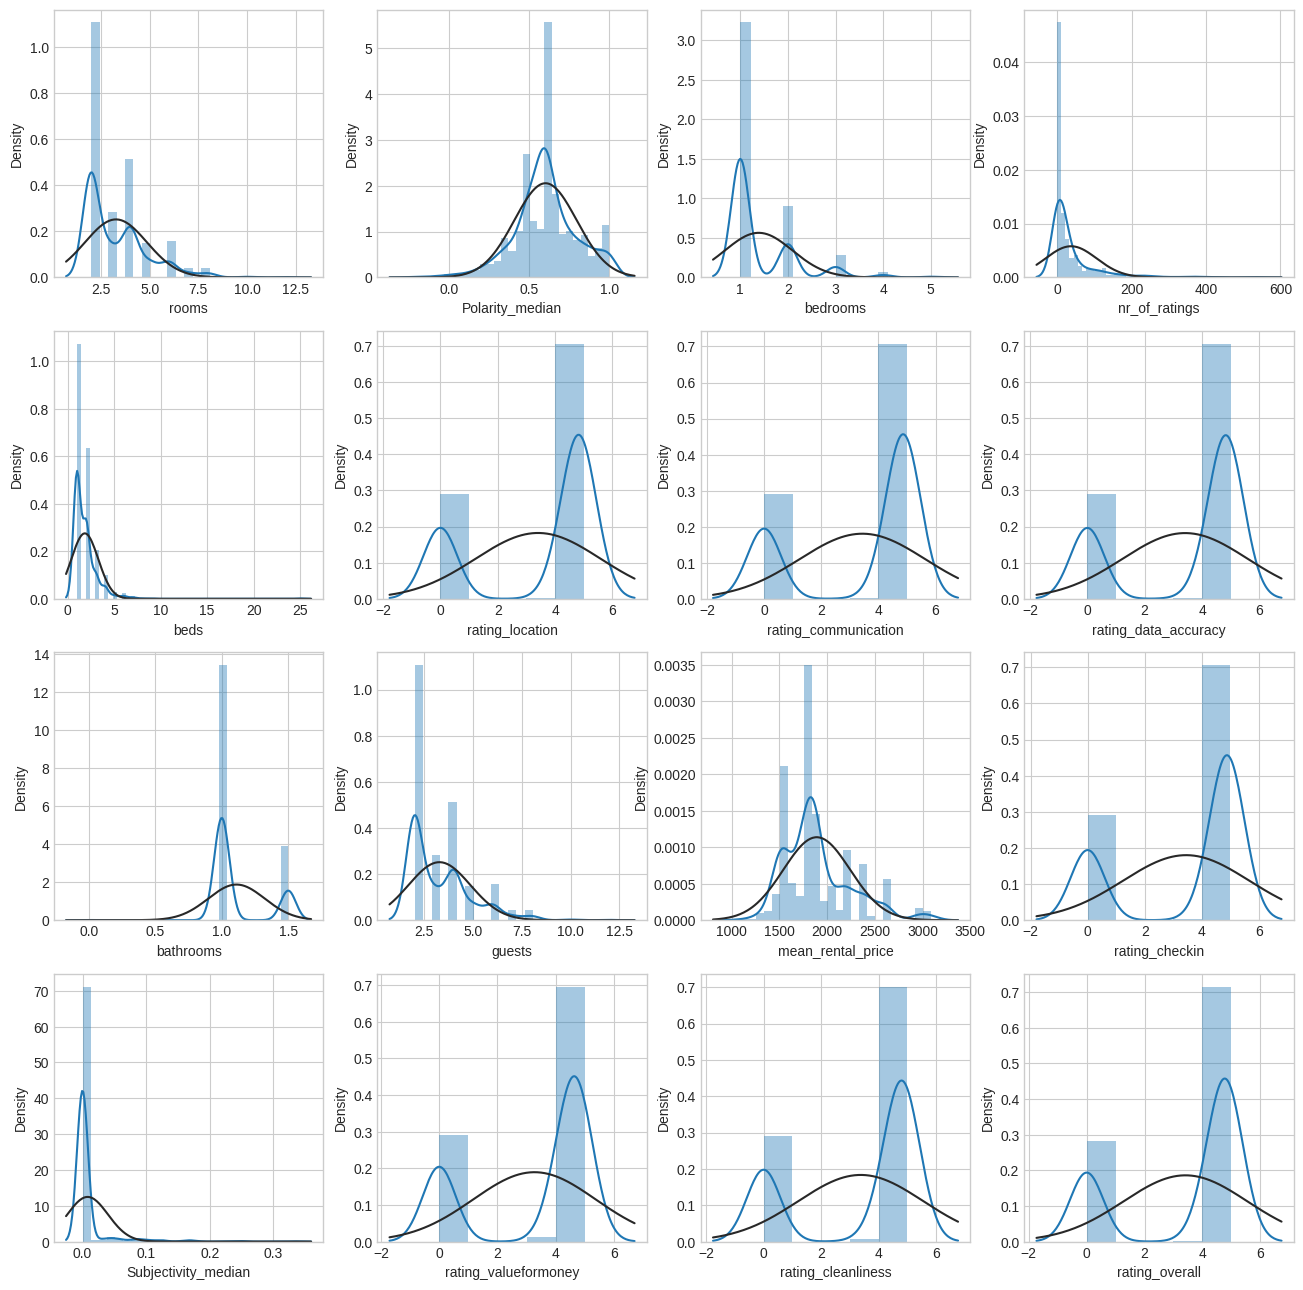

In [18]:
from scipy.stats import norm
features = set(df.describe().columns) - set(['price_y'])
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(16, 16))
for i, f in enumerate(features):
    sns.distplot(df[f], fit=norm, ax=axs[int(i/4), i%4])

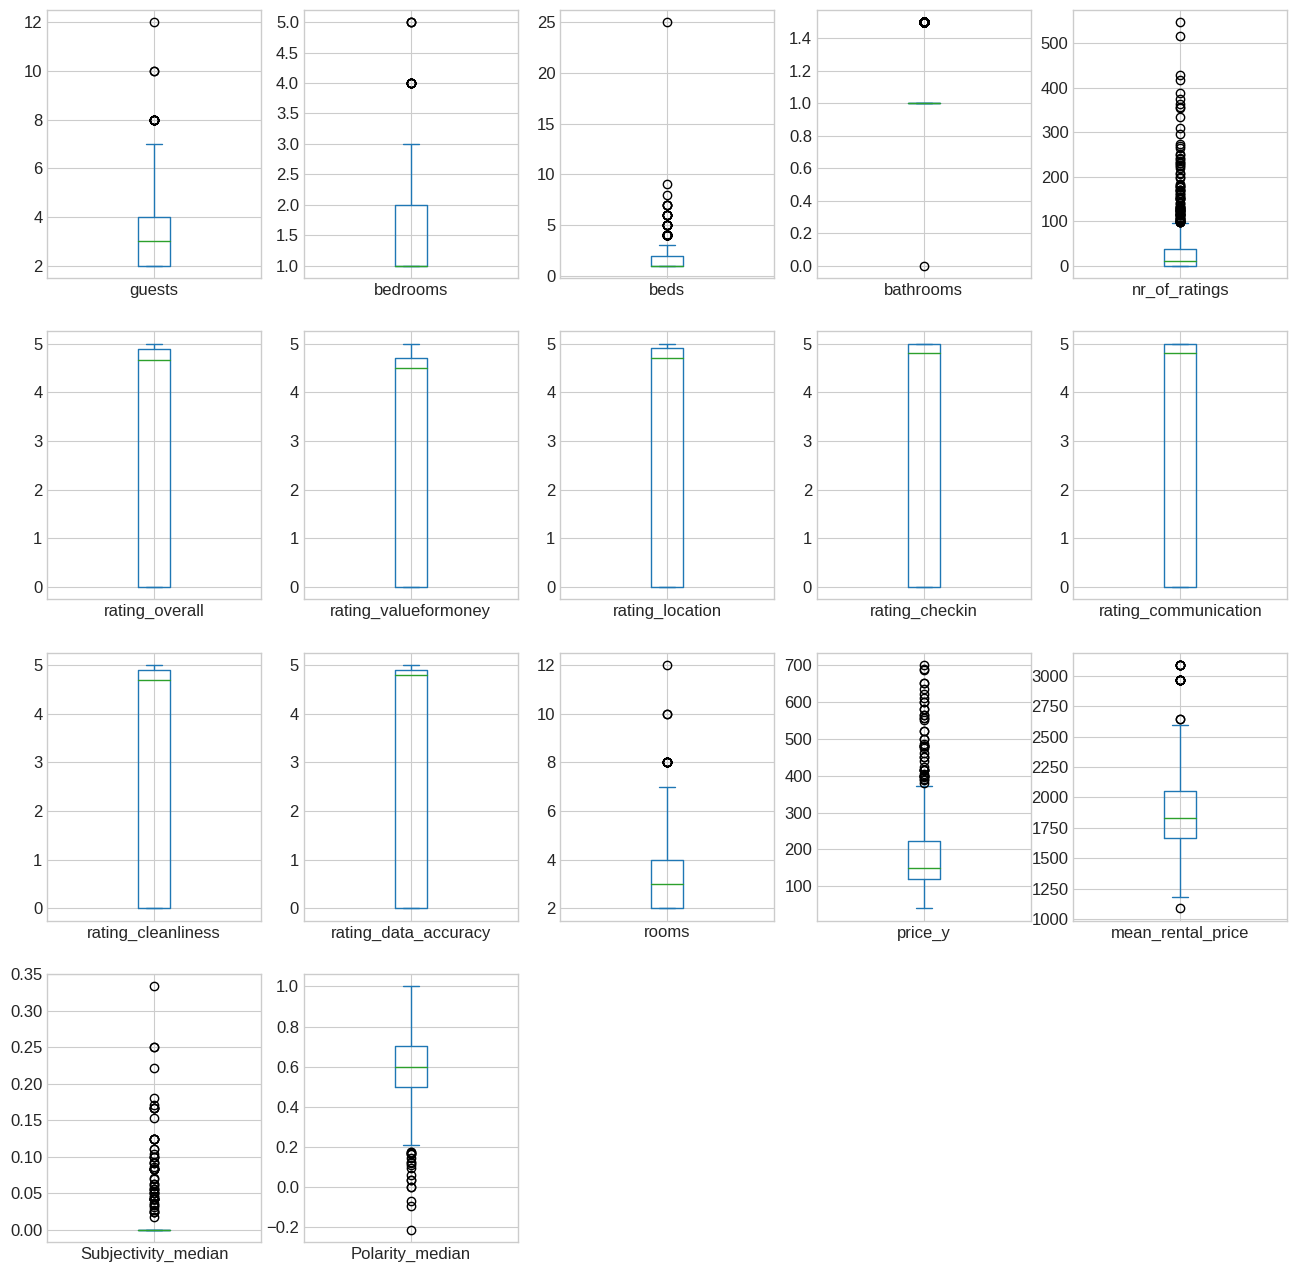

In [19]:
df.plot(kind="box", subplots=True, layout= (4,5), fontsize=12, figsize=(16,16));

In [20]:
df[df["beds"]>6]

,name,guests,bedrooms,beds,bathrooms,nr_of_ratings,rating_overall,rating_valueformoney,rating_location,rating_checkin,rating_communication,rating_cleanliness,rating_data_accuracy,rooms,price_y,district,mean_rental_price,Subjectivity_median,Polarity_median
295,Wohnung Oli,6,3,7,1.0,13,4.38,4.3,4.7,4.8,4.6,4.7,4.5,6,146.0,Unterstrass,1830.0,0.000,0.566667
382,"Schöne, grosse Wohnung",5,2,7,1.5,18,4.63,4.8,4.4,4.6,4.8,4.8,4.9,5,155.0,Wollishofen,1830.0,0.000,0.375000
579,Cozy flat in the new hype area of Zürich,4,2,25,1.5,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4,200.0,Sihlfeld,2051.0,0.125,0.618056
585,120 qm - 3 Schlafzimmer + Lounge im Zentrum vo...,10,3,9,1.5,10,4.56,4.2,4.9,4.7,5.0,4.6,4.7,10,210.0,Sihlfeld,1830.0,0.000,0.283333
628,Ruhige Familienwohnung mit Dachterasse im Zentrum,6,3,7,1.5,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,6,350.0,Sihlfeld,1830.0,0.000,0.955000
647,"Ruhiges Stadthaus, 20 Min. vom Stadtzentrum & See",7,4,7,1.5,3,5.00,4.7,5.0,5.0,5.0,5.0,5.0,7,350.0,Albisrieden,1830.0,0.000,0.530000
696,Casa Blumer - Villa / Garten für max. 12 Personen,12,3,8,1.5,19,4.95,4.8,5.0,5.0,4.9,4.8,4.9,12,686.0,Unterstrass,1830.0,0.000,0.706250


In [21]:
df.loc[579, 'beds'] = 4
df.loc[382, 'beds'] = 5
df.loc[295, 'beds'] = 6
df.loc[628, 'beds'] = 6

In [22]:
# Funktion zur Berechnung der Whiskers:
def iqr_fences(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lowerFence = Q1 - (1.5 * IQR)
    upperFence = Q3 + (1.5 * IQR)
    return lowerFence, upperFence

In [23]:
df_num = df[df.describe().columns]

for label, content in df_num.items():
        Q1 = content.quantile(0.25)
        Q3 = content.quantile(0.75)
        IQR = Q3 - Q1
        v_col = content[(content <= Q1 - 1.5 * IQR) | (content >= Q3 + 1.5 * IQR)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print("Spalte {} Anteil an Outliers = {}%".format(label, round(perc, 2)))

Spalte guests Anteil an Outliers = 4.14%
Spalte bedrooms Anteil an Outliers = 1.85%
Spalte beds Anteil an Outliers = 8.27%
Spalte bathrooms Anteil an Outliers = 100.0%
Spalte nr_of_ratings Anteil an Outliers = 12.7%
Spalte rating_overall Anteil an Outliers = 0.0%
Spalte rating_valueformoney Anteil an Outliers = 0.0%
Spalte rating_location Anteil an Outliers = 0.0%
Spalte rating_checkin Anteil an Outliers = 0.0%
Spalte rating_communication Anteil an Outliers = 0.0%
Spalte rating_cleanliness Anteil an Outliers = 0.0%
Spalte rating_data_accuracy Anteil an Outliers = 0.0%
Spalte rooms Anteil an Outliers = 4.14%
Spalte price_y Anteil an Outliers = 6.42%
Spalte mean_rental_price Anteil an Outliers = 2.85%
Spalte Subjectivity_median Anteil an Outliers = 100.0%
Spalte Polarity_median Anteil an Outliers = 2.57%


In [24]:
for i in df_num.columns:
    result = iqr_fences(df[i])
    lowerFence = result[0]
    upperFence = result[1]
    print("Lower Fence of {}: {}".format(i,lowerFence))
    print("Upper Fence of {}: {}".format(i, upperFence))
    
#(In Anlehnung an Dutli, D., 2020)

Lower Fence of guests: -1.0
Upper Fence of guests: 7.0
Lower Fence of bedrooms: -0.5
Upper Fence of bedrooms: 3.5
Lower Fence of beds: -0.5
Upper Fence of beds: 3.5
Lower Fence of bathrooms: 1.0
Upper Fence of bathrooms: 1.0
Lower Fence of nr_of_ratings: -57.0
Upper Fence of nr_of_ratings: 95.0
Lower Fence of rating_overall: -7.334999999999999
Upper Fence of rating_overall: 12.224999999999998
Lower Fence of rating_valueformoney: -7.050000000000001
Upper Fence of rating_valueformoney: 11.75
Lower Fence of rating_location: -7.3500000000000005
Upper Fence of rating_location: 12.25
Lower Fence of rating_checkin: -7.5
Upper Fence of rating_checkin: 12.5
Lower Fence of rating_communication: -7.5
Upper Fence of rating_communication: 12.5
Lower Fence of rating_cleanliness: -7.3500000000000005
Upper Fence of rating_cleanliness: 12.25
Lower Fence of rating_data_accuracy: -7.3500000000000005
Upper Fence of rating_data_accuracy: 12.25
Lower Fence of rooms: -1.0
Upper Fence of rooms: 7.0
Lower Fenc

In [25]:
lowerFence, upperFence = iqr_fences(df['price_y'])

#Print-Statement für Whiskers
print("Min-Whisker: {}".format(lowerFence)) 
print("Max-Whisker: {}".format(upperFence))

Min-Whisker: -37.0
Max-Whisker: 379.0


In [26]:
# Print Anzahl der Datensätze, welche überhalb dem Max-Whisker liegen:
print(len(df[df['price_y'] > 379.0]))
print(len(df[df['price_y'] < -37.0]))

45
0


In [27]:
# maybe drop them...
df[df['price_y'] > 379.0]

,name,guests,bedrooms,beds,bathrooms,nr_of_ratings,rating_overall,rating_valueformoney,rating_location,rating_checkin,rating_communication,rating_cleanliness,rating_data_accuracy,rooms,price_y,district,mean_rental_price,Subjectivity_median,Polarity_median
14,Kinder- und hundefreundliche Wohnung für bis z...,8,4,5,1.0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,8,500.0,Höngg,1830.0,0.125000,0.662500
27,Wohnung voll ausgestattet mit Aussicht in der ...,4,2,2,1.0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4,600.0,Unterstrass,2206.0,0.000000,0.500000
40,*Luxus-Penthouse im Herzen des trendigen Zürich*,3,2,2,1.5,30,4.97,4.8,4.9,5.0,4.9,4.9,5.0,3,650.0,Höngg,1830.0,0.000000,0.755000
591,"Innenstadt-Penthouse-Apartment, einschließlich...",7,3,4,1.5,363,4.85,4.7,4.9,4.9,4.9,4.8,4.9,7,405.0,Werd,1830.0,0.000000,0.500000
594,Übernachte im ♥ of Zurich - Apt im historische...,2,1,1,1.0,8,5.00,4.8,5.0,4.9,5.0,4.6,4.9,2,400.0,Werd,1895.0,0.000000,0.597619
598,Top Lake Side Lage mit dem Flugzeug,8,2,3,1.5,94,4.77,4.5,4.9,4.9,4.8,4.8,4.8,8,415.0,Mühlebach,1830.0,0.000000,0.841667
601,Einzigartiges 3BR-Dach Duplex - in der Nähe vo...,8,3,4,1.5,128,4.25,4.1,4.3,4.7,4.2,4.3,4.3,8,415.0,Werd,1830.0,0.000000,0.332143
603,numa | Moderne Maisonette in Zürich,6,1,3,1.0,3,4.67,5.0,4.7,5.0,5.0,5.0,5.0,6,416.0,Werd,1830.0,0.000000,1.000000
611,"Wunderschöne, ruhige und zentrale Altbau-Wohnung",2,1,1,1.5,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2,380.0,Unterstrass,1522.0,0.000000,0.225000
623,N5 Apartment im Herzen von Zürich,3,1,2,1.0,41,4.54,4.5,5.0,4.9,4.8,4.8,4.7,3,424.0,Hottingen,2389.0,0.000000,0.570000


### Feature selection

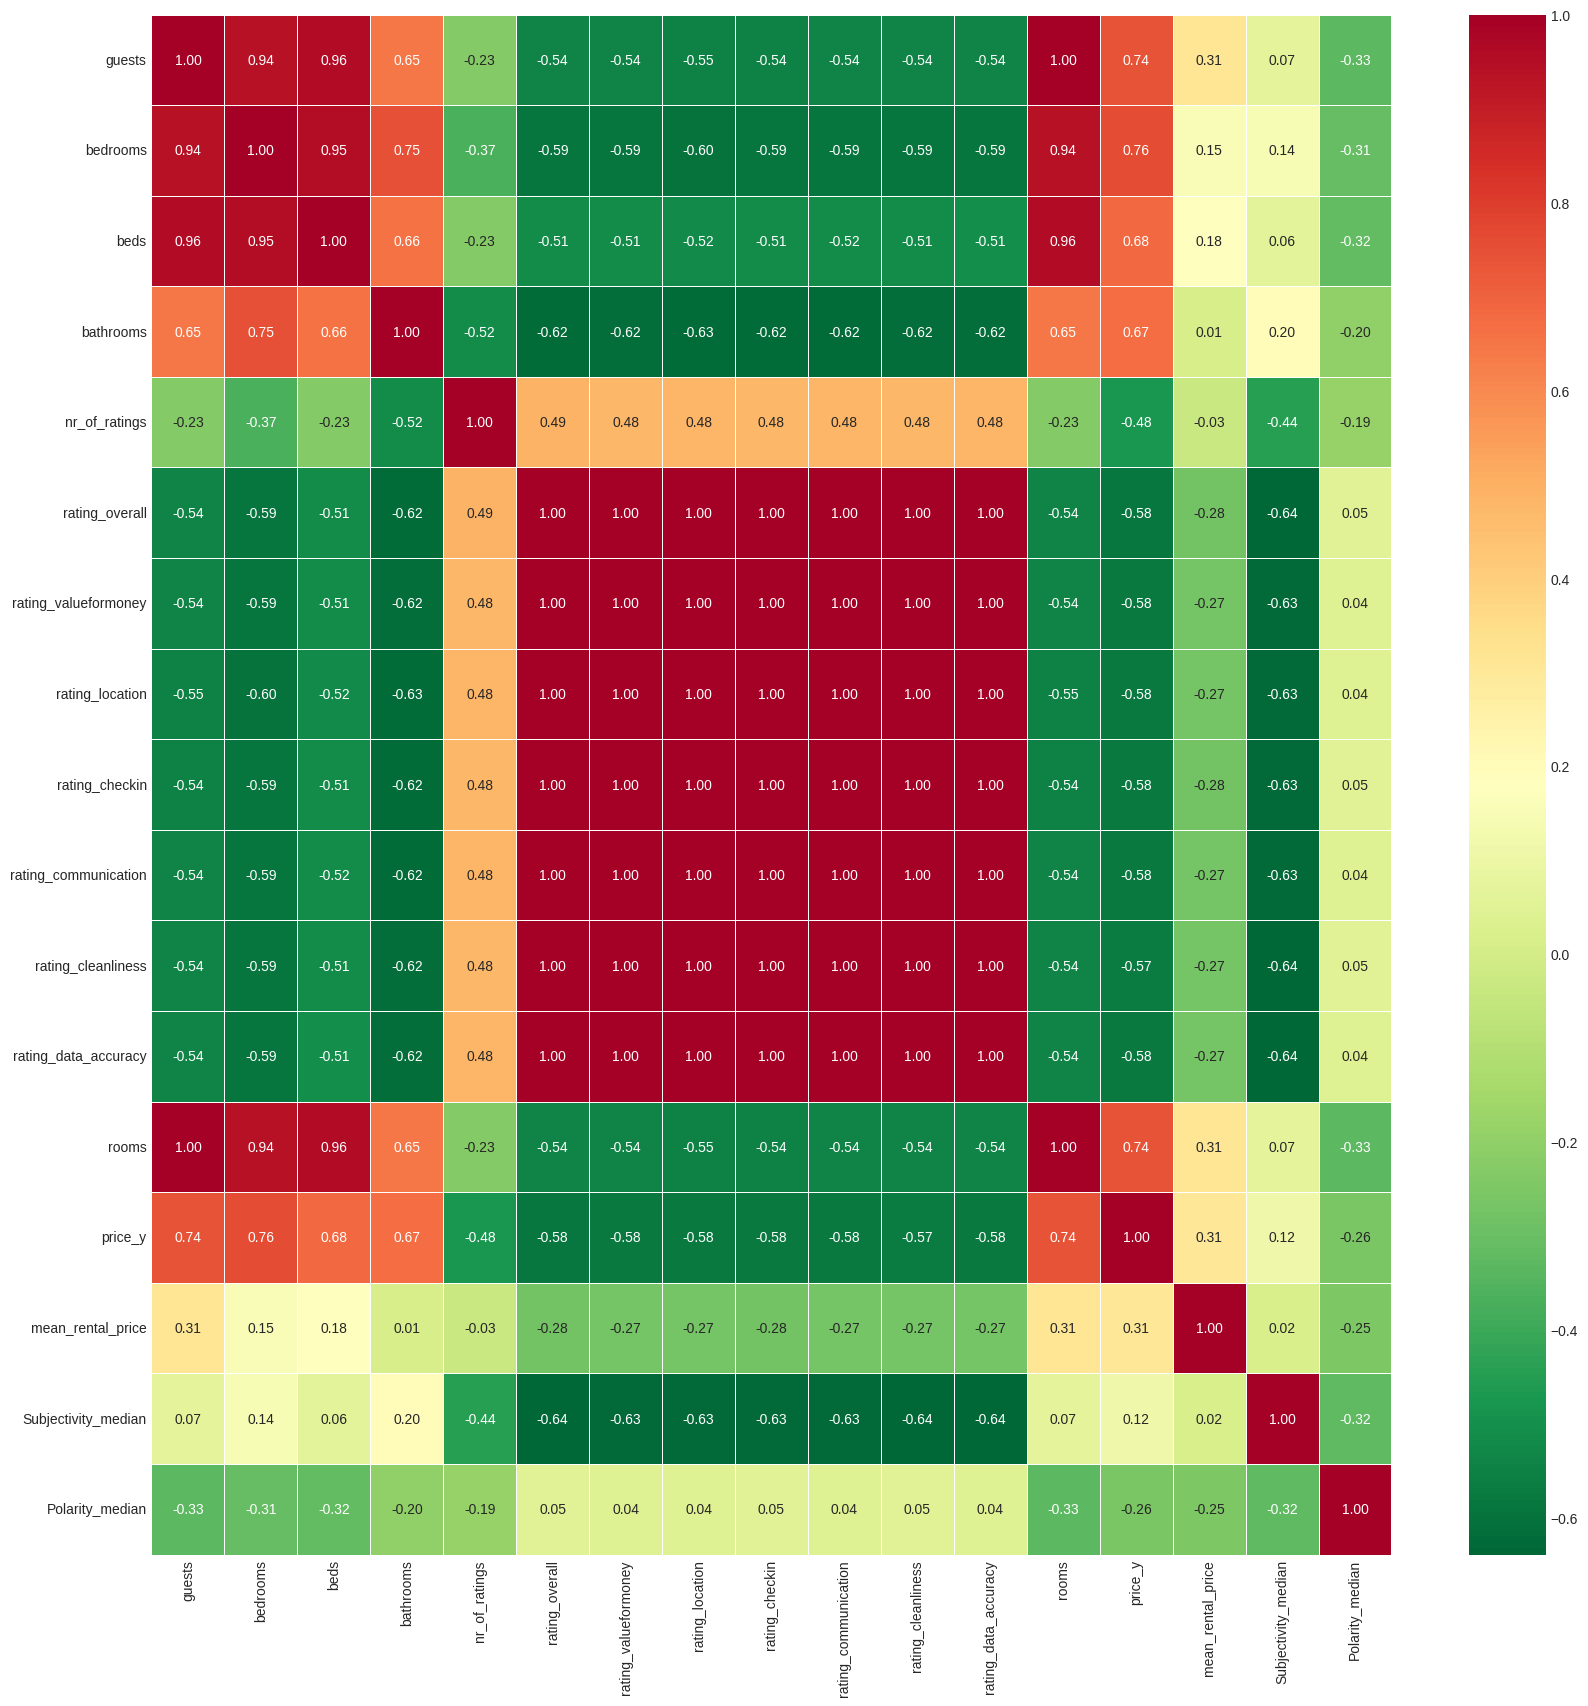

In [28]:
import seaborn as sns
df_heatmap = df[df.describe().columns].corr().round(2)
#plot correlation heatmap
plt.subplots(figsize=(20, 20))
heatmap = sns.heatmap(df_heatmap.corr(), annot=True, cmap='RdYlGn_r', linewidths=0.5, fmt='.2f') # type: ignore
heatmap = heatmap.get_figure()

Following features seem to be intresting to use for the model:
- guests
- bedrooms
- beds
- bathrooms
- nr_of_ratings
- rating_overall
- rooms
- mean_rental_price
- Polarity_median

"district" could be added later to try to improve model performance

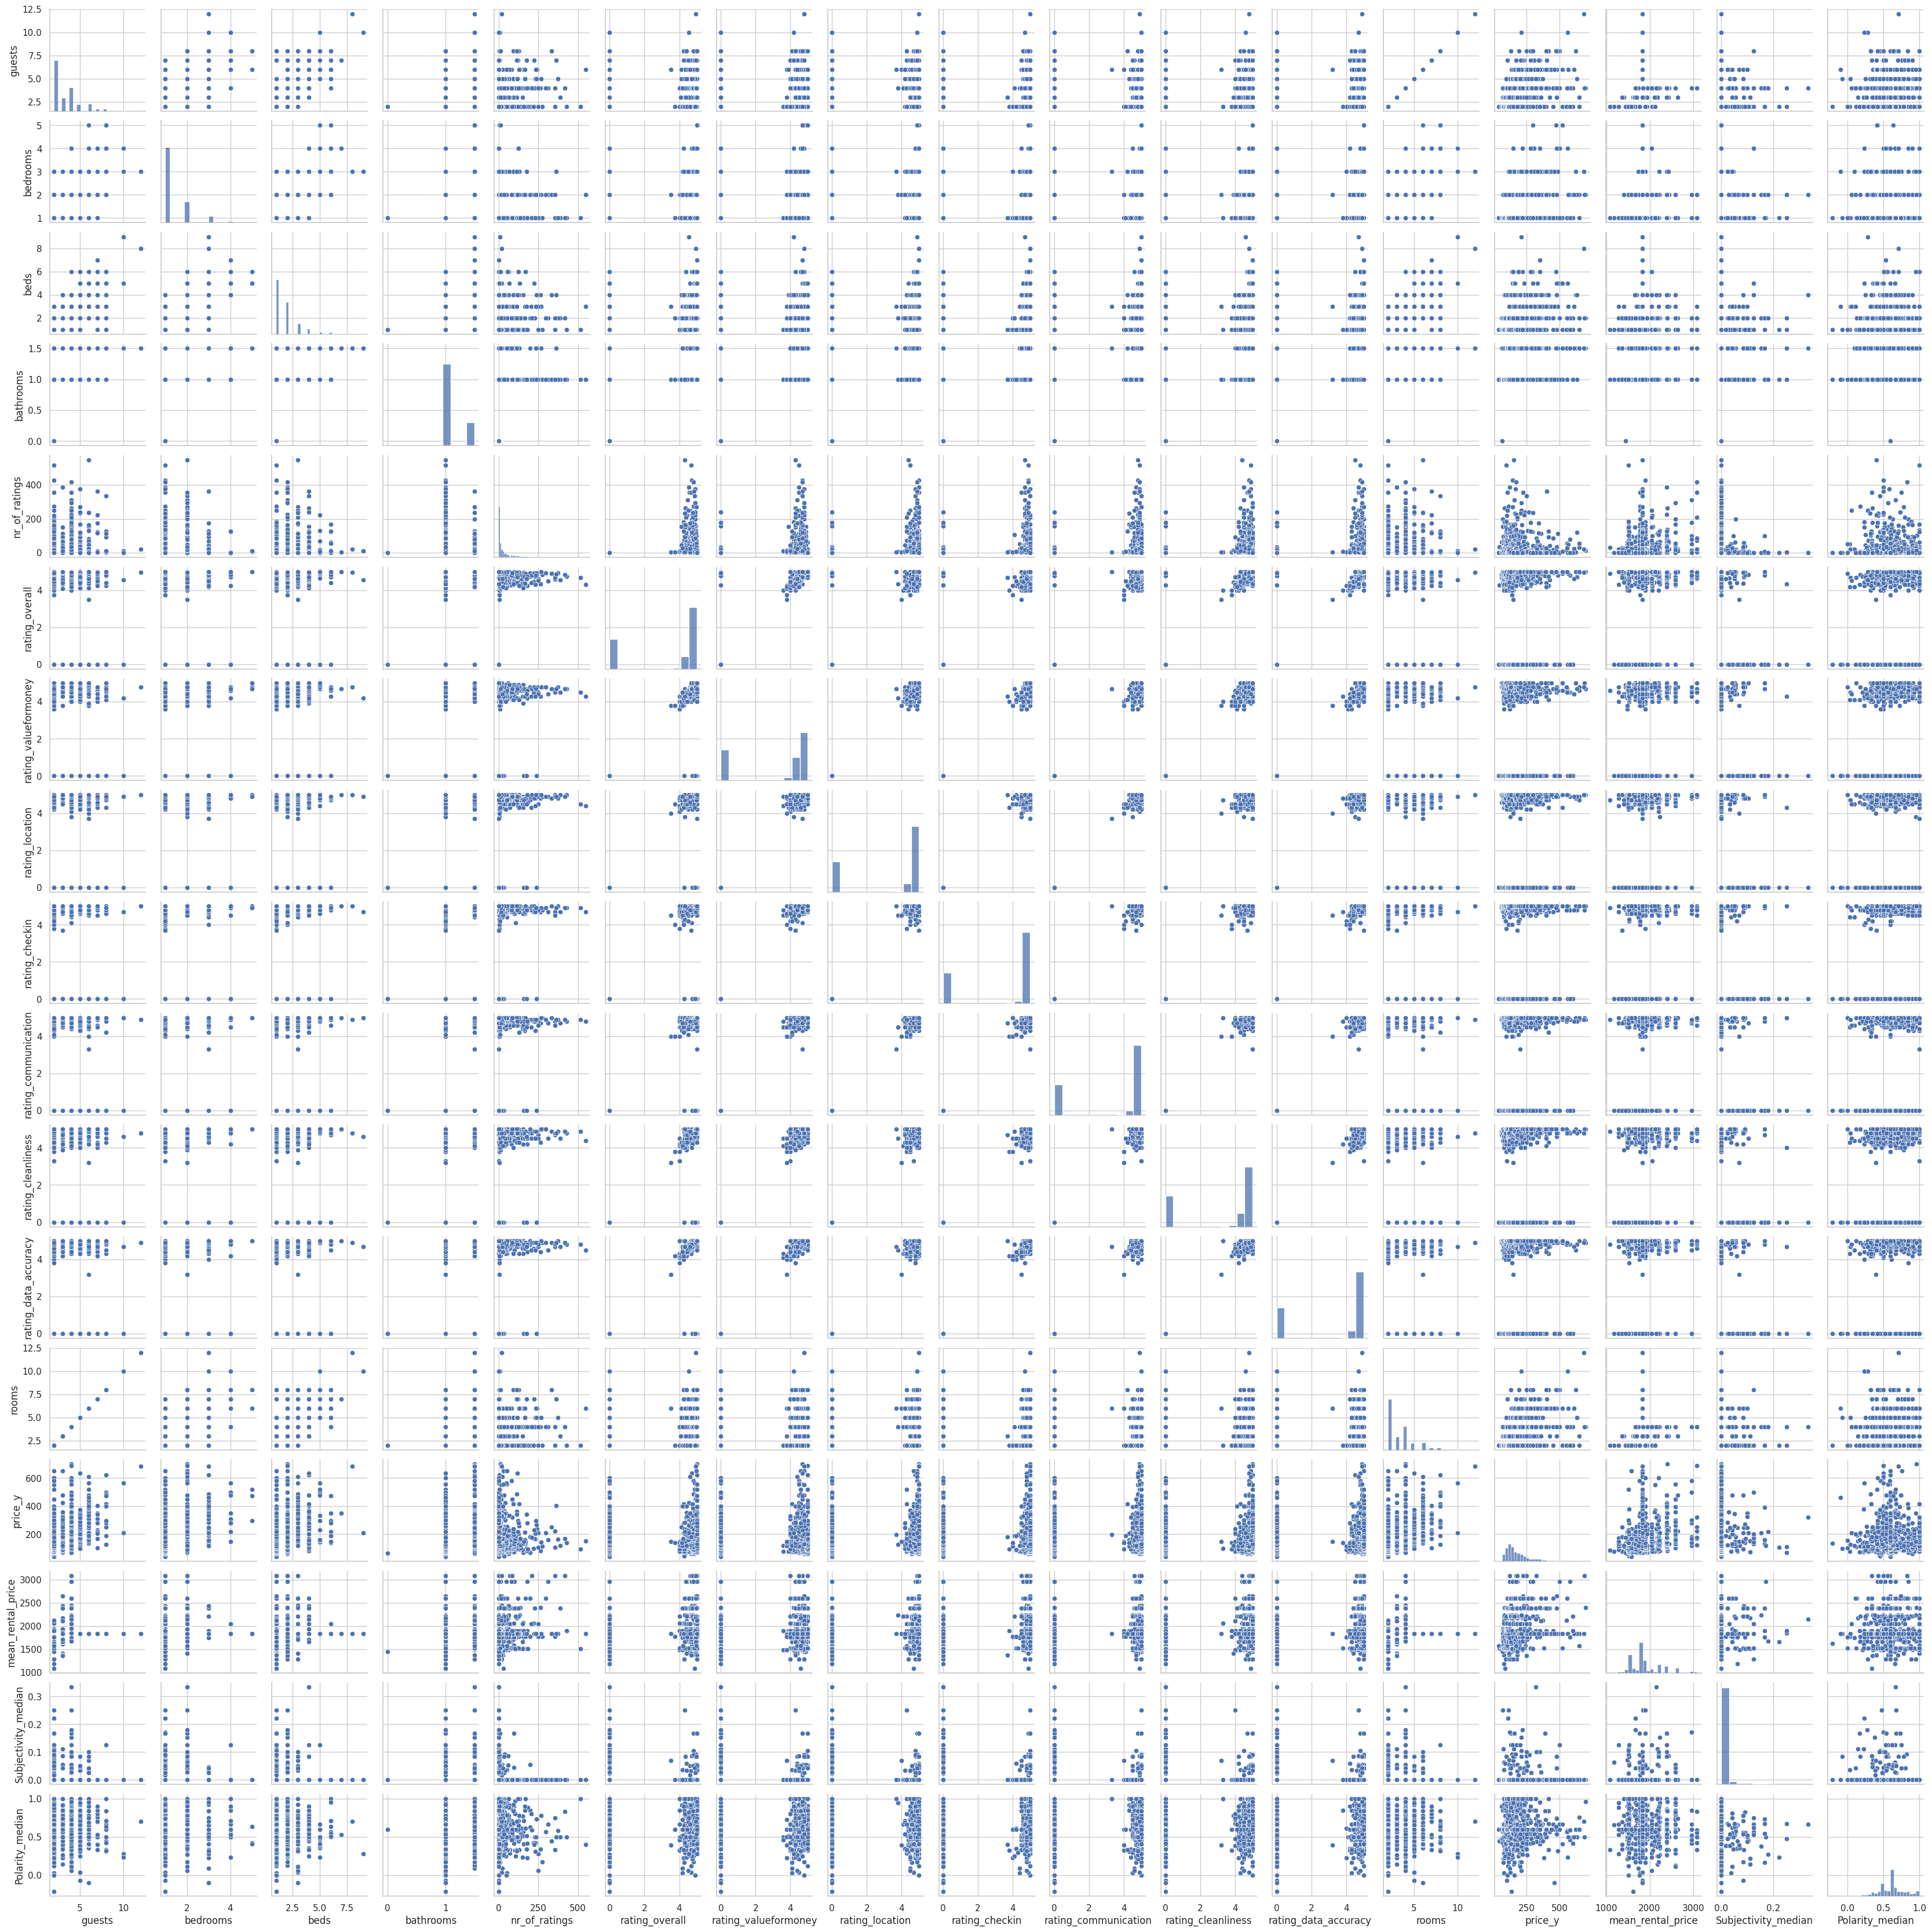

In [29]:
feature_names = df[df.describe().columns]

sns.set(style='whitegrid',context='notebook')
cols=feature_names
sns.pairplot(cols,height=2)
plt.show()

In [30]:
df.columns.values

array(['name', 'guests', 'bedrooms', 'beds', 'bathrooms', 'nr_of_ratings',
       'rating_overall', 'rating_valueformoney', 'rating_location',
       'rating_checkin', 'rating_communication', 'rating_cleanliness',
       'rating_data_accuracy', 'rooms', 'price_y', 'district',
       'mean_rental_price', 'Subjectivity_median', 'Polarity_median'],
      dtype=object)

In [160]:
# mean_rental_price does not improve model performance
# df_features = df[['guests','bedrooms', 'beds', 'bathrooms', 'nr_of_ratings', 'rating_overall', 'rooms', 'price_y', 'Polarity_median', 'mean_rental_price']]
# Polarity_median does not impact model significant
df_features = df[['guests','bedrooms', 'beds', 'bathrooms', 'nr_of_ratings', 'rating_overall', 'rooms', 'price_y']]

df_features_distric = df[['guests', 'bedrooms', 'beds', 'bathrooms', 'nr_of_ratings', 'rating_overall', 'rooms', 'price_y', 'mean_rental_price', 'Polarity_median', 'district']]

#hot encode district feature
df_features_distric = pd.concat([df_features_distric, pd.get_dummies(df_features_distric.district)], axis='columns')
df_features_distric.drop("district", axis='columns', inplace=True)
df_features_distric = df_features_distric.astype(int)

In [161]:
df_features.head()

,guests,bedrooms,beds,bathrooms,nr_of_ratings,rating_overall,rooms,price_y
0,2,1,1,1.0,36,4.28,2,44.0
1,2,1,1,1.0,0,0.00,2,40.0
2,2,1,1,1.0,3,4.67,2,62.0
3,2,1,1,1.0,0,0.00,2,66.0
4,2,1,1,0.0,0,0.00,2,64.0


In [162]:
## adding the hot encoded distric features makes the model worse
df_features_distric.head()

,guests,bedrooms,beds,bathrooms,nr_of_ratings,rating_overall,rooms,price_y,mean_rental_price,Polarity_median,...,Saatlen,Schwamendingen-Mitte,Seebach,Seefeld,Sihlfeld,Unterstrass,Weinegg,Werd,Witikon,Wollishofen
0,2,1,1,1,36,4,2,44,1522,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,1,1,0,0,2,40,1573,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,1,3,4,2,62,1522,0,...,0,0,0,0,0,1,0,0,0,0
3,2,1,1,1,0,0,2,66,1518,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,1,0,0,0,2,64,1445,0,...,0,0,1,0,0,0,0,0,0,0


# Traning, Test & Modell-Evaluation

In [163]:
X = df_features
X = X.astype("float") 
y = df_features.price_y

In [164]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
print("X_train:", X_train.shape)
print("y_train", y_train.shape)
print("X_test:", X_test.shape)
print("y_test", y_test.shape)

X_train: (560, 8)
y_train (560,)
X_test: (141, 8)
y_test (141,)


In [165]:
df_features.columns.values.tolist()

['guests',
 'bedrooms',
 'beds',
 'bathrooms',
 'nr_of_ratings',
 'rating_overall',
 'rooms',
 'price_y']

In [166]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
scaled = scaler.transform(X_train)

for i, col in enumerate(df_features.columns.values.tolist()):
    X_train[col] = scaled[:,i]


scaled_test = scaler.transform(X_test)

print('Vor dem Scaling:')
display(X_test.head())

for i, col in enumerate(df_features.columns.values.tolist()):
    X_test[col] = scaled_test[:,i]

print('\nNach dem Scaling:')
display(X_test.head())

Vor dem Scaling:


,guests,bedrooms,beds,bathrooms,nr_of_ratings,rating_overall,rooms,price_y
680,6.0,2.0,3.0,1.5,48.0,4.88,6.0,565.0
164,4.0,1.0,2.0,1.0,131.0,4.69,4.0,120.0
54,2.0,1.0,1.0,1.0,6.0,4.40,2.0,85.0
640,4.0,2.0,2.0,1.0,0.0,0.00,4.0,220.0
606,6.0,2.0,3.0,1.5,235.0,4.79,6.0,297.0



Nach dem Scaling:


,guests,bedrooms,beds,bathrooms,nr_of_ratings,rating_overall,rooms,price_y
680,0.50,0.25,0.250,1.000000,0.087751,0.976,0.50,0.795455
164,0.25,0.00,0.125,0.666667,0.239488,0.938,0.25,0.121212
54,0.00,0.00,0.000,0.666667,0.010969,0.880,0.00,0.068182
640,0.25,0.25,0.125,0.666667,0.000000,0.000,0.25,0.272727
606,0.50,0.25,0.250,1.000000,0.429616,0.958,0.50,0.389394


In [167]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Wir kreiren hier einen Benchmarkregressor, welcher den Durchschnittswert unseres Trainingsamples als Vorhersage nimmt.
class BenchmarkRegressor:
    def __init__(self):
        pass
    
    def fit(self, X, y, **kwargs):
        self.mean = y.mean()
        
    def predict(self, X):
        return [self.mean] * len(X)
    
    def get_params(self, deep=False):
        return {}

dummy = DummyRegressor(strategy="median")
bm_regr = BenchmarkRegressor()
lr_regr = LinearRegression()
ri_regr = Ridge()
br_regr = BayesianRidge()
ls_regr = Lasso()
ll_regr = LassoLars()
ne_regr = KNeighborsRegressor()
dt_regr = DecisionTreeRegressor()
rf_regr = RandomForestRegressor()
xg_regr = xgb.XGBRegressor()

# Liste mit dem Namen der Modelle und dem Modell selbst, dies erwartet das Pipeline Objekt von SKLearn anschliesssend als Input.
models = [
    ('dummy', dummy),
    ('Benchmark', bm_regr),
    ('LR', lr_regr),
    ('Ridge', ri_regr),
    ('Bayesian Ridge', br_regr),
    ('Lasso', ls_regr),
    ('LARS Lasso', ll_regr),
    ('Nearest Neighbors (KNN) regression', ne_regr),
    ('Decision Tree', dt_regr),
    ('Random Forest', rf_regr),
    ('XGBoost', xg_regr),
]

In [168]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion, Pipeline


for name, model in models:
    pipelined_model = Pipeline([ 
                                 ('pca', PCA(n_components = 3)), 
                                 (name, model)
                            ])
    
    # Training des Models
    pipelined_model.fit(X_train, y_train)
    
    # Vorhersage des trainierten models auf X_test
    y_hat = pipelined_model.predict(X_test)
    
    # Berechnung der verschiedenen Messwerte resp. KPI's
    EVS = (explained_variance_score(y_test, y_hat))
    ME = (max_error(y_test, y_hat))
    MAE = (mean_absolute_error(y_test, y_hat))
    MSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=True))
    RMSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=False))
    R2 = r2_score(y_test, y_hat)
    print('Model: ', name, ' | EVS: ', EVS)
    print('Model: ', name, ' | ME: ', ME)
    print('Model: ', name, ' | MAE: ', MAE)
    print('Model: ', name, ' | MSE ', MSE)
    print('Model: ', name, ' | RMSE ', RMSE)
    print('Model: ', name, ' | R2 ', R2)
    print('----------------')

Model:  dummy  | EVS:  -2.220446049250313e-16
Model:  dummy  | ME:  533.5
Model:  dummy  | MAE:  67.96099290780141
Model:  dummy  | MSE  109.88050408195699
Model:  dummy  | RMSE  10.482390189358389
Model:  dummy  | R2  -0.050861918712864496
----------------
Model:  Benchmark  | EVS:  -2.220446049250313e-16
Model:  Benchmark  | ME:  494.9535714285714
Model:  Benchmark  | MAE:  79.23994427558257
Model:  Benchmark  | MSE  108.14771469667195
Model:  Benchmark  | RMSE  10.399409343644088
Model:  Benchmark  | R2  -0.01797956825258029
----------------
Model:  LR  | EVS:  0.8163241201029455
Model:  LR  | ME:  141.14027380270284
Model:  LR  | MAE:  34.2606281517443
Model:  LR  | MSE  46.72763511597391
Model:  LR  | RMSE  6.835761487645243
Model:  LR  | R2  0.8099569586612224
----------------
Model:  Ridge  | EVS:  0.8165492824258529
Model:  Ridge  | ME:  151.40483469802666
Model:  Ridge  | MAE:  33.87887223146659
Model:  Ridge  | MSE  46.71791607124257
Model:  Ridge  | RMSE  6.835050553671317
M

## We are goging for Random Forest

In [169]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf_regr = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf_regr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [170]:
grid_search.fit(X_train, y_train)
print("Best params", grid_search.best_params_)
print("max r2", grid_search.best_score_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   

In [171]:
name = "RandomForestRegressor"

# Vorhersage des trainierten models auf X_test
y_hat = grid_search.predict(X_test)

# Berechnung der verschiedenen Messwerte resp. KPI's
EVS = (explained_variance_score(y_test, y_hat))
ME = (max_error(y_test, y_hat))
MAE = (mean_absolute_error(y_test, y_hat))
MSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=True))
RMSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=False))
R2 = r2_score(y_test, y_hat)
print('Model: ', name, ' | EVS: ', EVS)
print('Model: ', name, ' | ME: ', ME)
print('Model: ', name, ' | MAE: ', MAE)
print('Model: ', name, ' | MSE ', MSE)
print('Model: ', name, ' | RMSE ', RMSE)
print('Model: ', name, ' | R2 ', R2)
print('----------------')

Model:  RandomForestRegressor  | EVS:  0.9527923325029625
Model:  RandomForestRegressor  | ME:  171.98750323631862
Model:  RandomForestRegressor  | MAE:  10.381884733671658
Model:  RandomForestRegressor  | MSE  23.305735282633332
Model:  RandomForestRegressor  | RMSE  4.827601400554247
Model:  RandomForestRegressor  | R2  0.952725168829529
----------------


In [172]:
# predict the first 3 apartments
X_test[0:3]

,guests,bedrooms,beds,bathrooms,nr_of_ratings,rating_overall,rooms,price_y
680,0.50,0.25,0.250,1.000000,0.087751,0.976,0.50,0.795455
164,0.25,0.00,0.125,0.666667,0.239488,0.938,0.25,0.121212
54,0.00,0.00,0.000,0.666667,0.010969,0.880,0.00,0.068182


In [173]:
# real price of the 3 apartments
y_test[0:3]

680    565.0
164    120.0
54      85.0
Name: price_y, dtype: float64

In [174]:
# model predictions
result = grid_search.predict(X_test[0:3])
result

array([509.86951663, 128.5975606 ,  93.08973938])